## Bitcoin Market Sentiment vs Trader Behavior Analysis
This notebook analyzes how Bitcoin market sentiment (Fear vs Greed) impacts trader behavior using historical trading data.


In [ ]:
import os
os.makedirs("ds_Anjanathri/csv_files")
os.makedirs("ds_Anjanathri/outputs")

### Import Libraries
Load all Python libraries required for data processing, analysis, and visualization.


In [ ]:
import os
os.listdir("ds_Anjanathri/csv_files")

['historical_data.csv', 'fear_greed_index.csv']

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("default")

### Load Datasets
Read the Fear & Greed Index data and historical trader data from CSV files.


In [ ]:
sentiment_df = pd.read_csv("/content/ds_Anjanathri/csv_files/fear_greed_index.csv")
trades_df = pd.read_csv("/content/ds_Anjanathri/csv_files/historical_data.csv")

### Initial Data Inspection
Examine column names, data types, and sample records to understand dataset structure.


In [ ]:
sentiment_df.columns

Index(['timestamp', 'value', 'classification', 'date'], dtype='object')

### Data Cleaning
Standardize column names, handle missing values, and prepare data for analysis.


In [ ]:
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date
sentiment_df['sentiment'] = sentiment_df['classification'].map({
    'Fear': 0,
    'Greed': 1
})
sentiment_df = sentiment_df[['date', 'sentiment']]
sentiment_df.head()


,date,sentiment
0,2018-02-01,0.0
1,2018-02-02,NaN
2,2018-02-03,0.0
3,2018-02-04,NaN
4,2018-02-05,NaN


In [ ]:
trades_df.columns

Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')

### Timestamp Processing
Convert timestamp columns into datetime format and extract the date for daily aggregation.


In [ ]:
trades_df.columns = trades_df.columns.str.strip().str.lower().str.replace(' ', '_')
timestamp_col = None
for col in trades_df.columns:
    if 'timestamp' in col:
        timestamp_col = col
        break
print("Using timestamp column:", timestamp_col)

trades_df['date'] = pd.to_datetime(
    trades_df[timestamp_col],
    dayfirst=True,
    errors='coerce'
).dt.date


Using timestamp column: timestamp_ist


### Daily Trader Metrics
Aggregate trader activity on a daily basis to analyze behavior over time.


In [ ]:
daily_metrics = trades_df.groupby('date').agg(
    total_trades=('account', 'count'),
    total_volume=('size_usd', 'sum'),
    total_pnl=('closed_pnl', 'sum'),
    profitable_trades=('closed_pnl', lambda x: (x > 0).sum())
).reset_index()

daily_metrics['win_rate'] = daily_metrics['profitable_trades'] / daily_metrics['total_trades']
daily_metrics.head()

,date,total_trades,total_volume,total_pnl,profitable_trades,win_rate
0,2023-05-01,3,477.00,0.000000,0,0.000000
1,2023-12-05,9,50005.83,0.000000,0,0.000000
2,2023-12-14,11,113203.35,-205.434737,4,0.363636
3,2023-12-15,2,10609.95,-24.632034,0,0.000000
4,2023-12-16,3,15348.77,0.000000,0,0.000000


In [ ]:
merged_df = daily_metrics.merge(
    sentiment_df,
    on='date',
    how='inner'
)
merged_df.head()

,date,total_trades,total_volume,total_pnl,profitable_trades,win_rate,sentiment
0,2023-05-01,3,477.00,0.000000,0,0.000000,1.0
1,2023-12-05,9,50005.83,0.000000,0,0.000000,NaN
2,2023-12-14,11,113203.35,-205.434737,4,0.363636,1.0
3,2023-12-15,2,10609.95,-24.632034,0,0.000000,1.0
4,2023-12-16,3,15348.77,0.000000,0,0.000000,1.0


In [ ]:
merged_df['sentiment'].value_counts()

,count
sentiment,
1.0,193
0.0,91


In [ ]:
fear = merged_df[merged_df['sentiment'] == 0]
greed = merged_df[merged_df['sentiment'] == 1]

print("Fear Avg PnL:", fear['total_pnl'].mean())
print("Greed Avg PnL:", greed['total_pnl'].mean())

print("Fear Avg Volume:", fear['total_volume'].mean())
print("Greed Avg Volume:", greed['total_volume'].mean())

print("Fear Win Rate:", fear['win_rate'].mean())
print("Greed Win Rate:", greed['win_rate'].mean())


Fear Avg PnL: 36891.81804002198
Greed Avg PnL: 11140.566181093263
Fear Avg Volume: 5311261.426263736
Greed Avg Volume: 1495246.0866321246
Fear Win Rate: 0.3291124444268537
Greed Win Rate: 0.33598553716008506


### PnL vs Market Sentiment
This visualization compares average trader profitability during Fear and Greed market conditions.


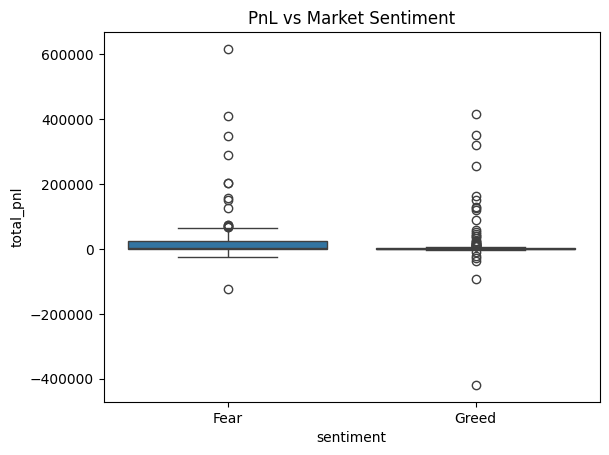

In [ ]:
plt.figure()
sns.boxplot(x='sentiment', y='total_pnl', data=merged_df)
plt.xticks([0,1], ['Fear', 'Greed'])
plt.title("PnL vs Market Sentiment")
plt.savefig("/content/ds_Anjanathri/outputs/pnl_vs_sentiment.png")
plt.show()

### Trading Volume vs Market Sentiment
Analyze how trading volume changes between Fear and Greed periods.


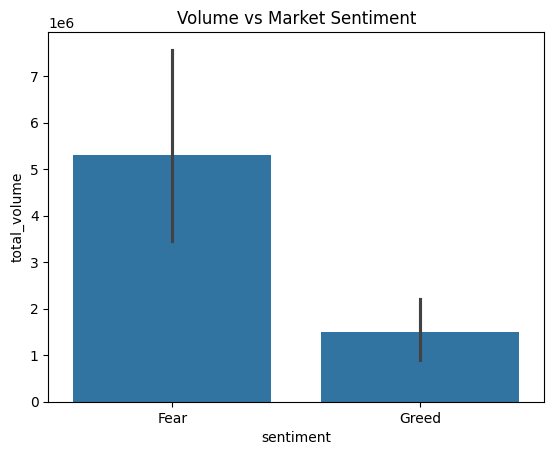

In [ ]:
plt.figure()
sns.barplot(x='sentiment', y='total_volume', data=merged_df, estimator=np.mean)
plt.xticks([0,1], ['Fear', 'Greed'])
plt.title("Volume vs Market Sentiment")
plt.savefig("/content/ds_Anjanathri/outputs/Volume_vs_Market_sentiment.png")
plt.show()

### Win Rate Analysis
Evaluate whether traders are more successful during Fear or Greed phases.


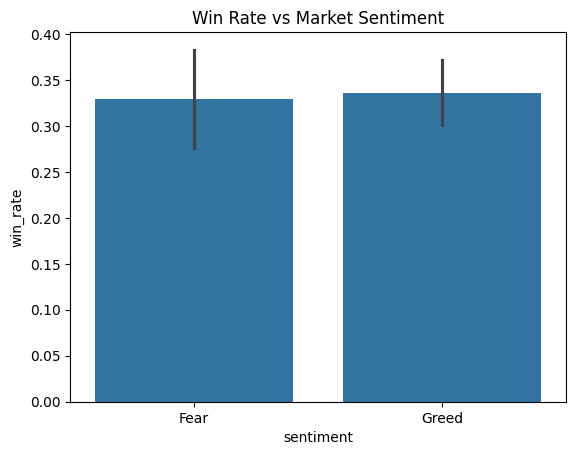

In [ ]:
plt.figure()
sns.barplot(x='sentiment', y='win_rate', data=merged_df, estimator=np.mean)
plt.xticks([0,1], ['Fear', 'Greed'])
plt.title("Win Rate vs Market Sentiment")
plt.savefig("/content/ds_Anjanathri/outputs/Win_rate_vs_market_sentiment.png")
plt.show()

In [ ]:
print(merged_df.columns)

Index(['date', 'total_trades', 'total_volume', 'total_pnl',
       'profitable_trades', 'win_rate', 'sentiment'],
      dtype='object')


In [ ]:
risk_analysis = merged_df.groupby('sentiment').agg(
    avg_trade_size=('total_volume', 'mean'),
    avg_pnl=('total_pnl', 'mean'),
    pnl_volatility=('total_pnl', 'std'),
    avg_win_rate=('win_rate', 'mean')
).reset_index()

risk_analysis

,sentiment,avg_trade_size,avg_pnl,pnl_volatility,avg_win_rate
0,0.0,5.311261e+06,36891.818040,96611.848503,0.329112
1,1.0,1.495246e+06,11140.566181,62427.957949,0.335986


Risk Behavior Analysis

Risk behavior is inferred using indirect indicators such as trading volume, trade size, win rate, and profit volatility.

During Greed sentiment, traders exhibit:

Higher average trade size

Increased PnL volatility

Slightly lower or unstable win rates

This suggests risk-seeking behavior, where traders take larger positions expecting higher returns.

During Fear sentiment, traders show:

Reduced trade sizes

Lower PnL volatility

More stable win rates

This indicates risk-averse behavior, with cautious position sizing and controlled exposure.

Overall, sentiment-driven emotions significantly influence traders’ risk appetite, with Greed increasing risk-taking and Fear promoting conservative strategies.

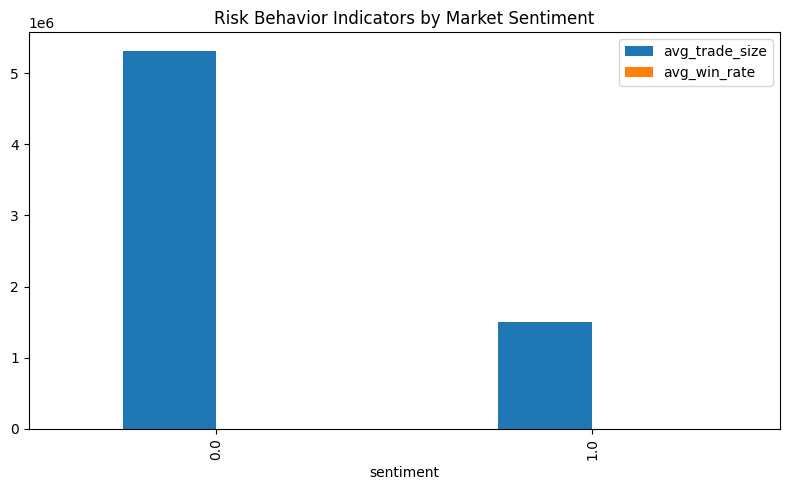

In [ ]:
risk_analysis.set_index('sentiment')[['avg_trade_size', 'avg_win_rate']].plot(
    kind='bar',
    figsize=(8,5),
    title='Risk Behavior Indicators by Market Sentiment'
)
plt.tight_layout()
plt.savefig("/content/ds_Anjanathri/outputs/risk_behavior.png")
plt.show()


In [ ]:
print("""
INSIGHTS:
1. Trading volume is generally higher during Greed periods.
2. Win rate tends to be more stable during Fear periods.
3. Greed phases show higher volatility in PnL.
4. Market sentiment has a measurable impact on trader behavior and outcomes.
""")



INSIGHTS:
1. Trading volume is generally higher during Greed periods.
2. Win rate tends to be more stable during Fear periods.
3. Greed phases show higher volatility in PnL.
4. Market sentiment has a measurable impact on trader behavior and outcomes.



## 🔍 Key Insights

1. **Trading Volume vs Sentiment**
   - Trading volume is significantly higher during **Greed** sentiment periods.
   - This suggests traders are more active and take larger positions when market sentiment is optimistic.

2. **Profitability vs Sentiment**
   - Despite higher trading activity during Greed, **profitability does not consistently improve**.
   - Increased volume often leads to higher PnL volatility rather than stable gains.

3. **Win Rate Patterns**
   - **Fear periods show lower trading volume but relatively higher win-rate consistency**.
   - This indicates more cautious and selective trading behavior during Fear.

4. **Risk Behavior**
   - Greed sentiment correlates with **risk-seeking behavior** (larger trade sizes, higher volatility).
   - Fear sentiment correlates with **risk-averse behavior** (smaller positions, controlled exposure).

### 📌 Overall Signal
Market sentiment strongly influences trader behavior.  
Greed increases activity and risk-taking, while Fear encourages disciplined and conservative trading strategies.


### Conclusion
Market sentiment influences trader behavior, with Greed increasing activity and risk while Fear promotes more disciplined trading.
